In [42]:
import numpy as np
import keras
import pandas as pd
import json
import imageio
from skimage.transform import resize
import os
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [213]:
def load_data(mode):
    if mode == 'TRAIN':
        json_path = '../../data/reference_images_part1.json'
        images_path = '../../data/reference_images_part1/'
    elif mode == 'VAL':
        json_path = '../../data/images_part1_valid.json'
        images_path = '../../data/images_part1_valid/'
    else:
        raise ValueError('usupported mode')
    with open(json_path) as json_data:
        data = json.load(json_data)
    images = pd.DataFrame(data['images'])
    annotations = pd.DataFrame(data['annotations'])
    categories = pd.DataFrame(data['categories'])
    
    df = pd.DataFrame()
    
    
    X = []
    y = []
    y_desc = []
    occluded = []
    bboxes = []
    im_ids = []
    
    for instance in data['annotations']:
        im_id = instance['image_id']
        bbox = instance['bbox']
        y.append(instance['category_id'])
        bboxes.append(np.asarray(bbox).astype('int64'))
        #print(images.loc[images['id']==im_id]['file_name'])
        im_ids.append(images.loc[images['id']==im_id]['file_name'].values[0])
        y_desc.append(categories.loc[categories['id']==instance['category_id']]['name'].values[0])
        if mode=='TRAIN':
            occluded.append(False)
        elif mode=='VAL':
            occluded.append(instance['occluded'])
        
    df['bbox'] = bboxes
    df['y'] = y
    df['desc'] = y_desc
    df['im_id'] = im_ids
    df['occ'] = occluded
    
    return df

In [171]:
df

,bbox,y,desc,im_id
0,"[665, 448, 206, 174]",8,nomagic_mulled_wine,nomagic_mulled_wine_3.png
1,"[475, 186, 236, 186]",8,nomagic_mulled_wine,nomagic_mulled_wine_3.png
2,"[962, 76, 229, 217]",8,nomagic_mulled_wine,nomagic_mulled_wine_3.png
3,"[778, 250, 163, 135]",8,nomagic_mulled_wine,nomagic_mulled_wine_3.png
4,"[184, 377, 244, 194]",8,nomagic_mulled_wine,nomagic_mulled_wine_3.png
...,...,...,...,...
139,"[791, 129, 277, 139]",3,nomagic_digitec_cables,nomagic_digitec_cables_1.png
140,"[345, 139, 271, 109]",3,nomagic_digitec_cables,nomagic_digitec_cables_1.png
141,"[895, 365, 177, 223]",3,nomagic_digitec_cables,nomagic_digitec_cables_1.png
142,"[155, 146, 163, 209]",3,nomagic_digitec_cables,nomagic_digitec_cables_1.png


In [261]:
class LoadData:

    
    def __init__(self, mode):
        self.files = []
        self.mode = mode
        if mode == 'TRAIN':
            self.images_path = '../../data/reference_images_part1/'
            self.json_path = '../../data/reference_images_part1.json'
            self.df = train_df
        elif mode == 'VAL':
            self.json_path = '../../data/images_part1_valid.json'
            self.images_path = '../../data/images_part1_valid/'
            self.df = val_df
        else:
            raise ValueError('usupported mode')

        for file in os.listdir(self.images_path):
                    if file.endswith('.png'):
                        try:
                            self.files.append(os.path.join(self.images_path, file))
                        except FileNotFoundError as e:
                            print(file)

    def _get_file_index(self):
        return [i for i in self.files]


    def __getitem__(self, index):
        X = np.asarray(Image.open(self.images_path+self.df.iloc[index]['im_id']))
        X = X[self.df.iloc[index]['bbox'][1]:self.df.iloc[index]['bbox'][1]+self.df.iloc[index]['bbox'][3],
              self.df.iloc[index]['bbox'][0]:self.df.iloc[index]['bbox'][0]+self.df.iloc[index]['bbox'][2],
              :3]
        
        def normalize(x):
            return x/255
        
        def preprocessing(X):
            data_x = np.zeros((256,256,3))
            mean=109.9818118

            temp_df = X
            temp_df_shape = X.shape
    
            max_shape = np.max(temp_df_shape)
            max_shape_orient = np.where(temp_df_shape==max_shape) # zwróci 0 albo 1
            temp_arr = np.zeros((max_shape,max_shape,3)) ## mozna czymś wypełnić tło
            
            if max_shape_orient[0][0] == 0:
                t = (temp_df_shape[0] - temp_df_shape[1])//2
                temp_arr[:,t:t+temp_df_shape[1],:] = temp_df
    
            elif max_shape_orient[0][0] == 1:
                t = (temp_df_shape[1] - temp_df_shape[0])//2
                temp_arr[t:t+temp_df_shape[0],:,:] = temp_df
            
            
            data_x = resize(temp_arr, (256, 256))
        
            data_x = np.where(data_x==0,mean,data_x)   

            return data_x
        
        return np.reshape(preprocessing(X), (1, 256, 256, 3))

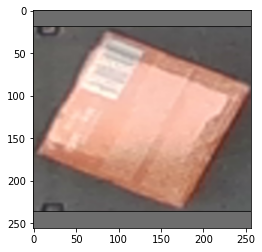

In [294]:
train_df = load_data('TRAIN')
loader = LoadData('TRAIN')
plt.imshow(loader[0][0].astype('int64'))

In [295]:
model_b7 = tf.keras.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling='max',
    classes=1000,
    classifier_activation="softmax")

In [296]:
embb7 = np.zeros((len(df), 2560))
for i in range(len(df)):
    embb7[i] = model_b7(loader[i])[0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 144 samples in 0.001s...
[t-SNE] Computed neighbors for 144 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 144 / 144
[t-SNE] Mean sigma: 25.140057
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.178940
[t-SNE] KL divergence after 1000 iterations: 0.352360


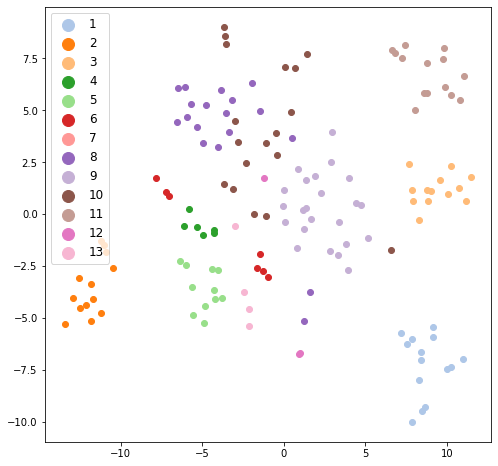

In [297]:
from sklearn.manifold import TSNE
from matplotlib import cm
import matplotlib.pyplot as plt

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(embb7)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 12
for lab in range(1, num_categories+2):
    indices = np.asarray(df['y'])==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=1)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [262]:
val_df = load_data('VAL')
val_gen = LoadData('VAL')

5

In [280]:
results = []
for i in range(len(val_df)):
    if(i>0 and len(val_df)%i==100):
        print(float(i)/len(val_df))
    if not val_df.iloc[i]['occ']:
        results.append(model_b7(val_gen[i])[0])
    else:
        results.append(np.NaN)

0.01669195751138088
0.017905918057663128
0.044764795144157814
0.08952959028831563
0.09848254931714719
0.19696509863429437
0.49241274658573597
0.9848254931714719


In [285]:
from scipy.spatial import distance
import numpy as np

MAX_CLASS = 13 #maksymalne id klasy


def compute_distances(x, embedding, method=distance.euclidean):
    distances = np.zeros((embedding.shape[0]))
    for i in range(embedding.shape[0]):
        distances[i] = method(embedding[i], x)
    return distances

In [299]:
distances=[]

for i in range(len(results)):
    if results[i] is not np.NaN:
        distances.append(compute_distances(results[i], embb7))
    else:
        distances.append(np.NaN)

In [340]:
def classify(distances, classes):
    '''
    same lengths
    distances - np.array
    classes - np.array
    returns: class
    '''
    weights = {cls: [] for cls in classes}
    for i in range(len(distances)):
        weights[classes[i]].append(distances[i])

    m = max(sum(list(map(lambda x: pow(x, -1), scores)))/len(scores) for scores in weights.values())
    for cls in weights.keys():
        lm = sum(list(map(lambda x: pow(x, -1), weights[cls])))/len(weights[cls])
        if lm == m:
            return cls


'''
distances = [0.2, 0.2, 0.5, 0.8, 0.7, 0.7, 0.6, 0.5, 0.9, 0.6, 0.4, 0.3, 0.05]
classes =   ['A', 'B', 'B', 'C', 'A', 'A', 'C', 'C', 'C', 'B', 'B', 'B', 'C']
print('max: ', classify(distances, classes))
'''

"\ndistances = [0.2, 0.2, 0.5, 0.8, 0.7, 0.7, 0.6, 0.5, 0.9, 0.6, 0.4, 0.3, 0.05]\nclasses =   ['A', 'B', 'B', 'C', 'A', 'A', 'C', 'C', 'C', 'B', 'B', 'B', 'C']\nprint('max: ', classify(distances, classes))\n"

In [341]:
predictions = []


for i in range(len(distances)):
    if distances[i] is not np.NaN:
        predictions.append(classify(distances[i], train_df['y']))
    else:
        predictions.append(np.NaN)

In [344]:
results_df = pd.DataFrame()
results_df['preds'] = predictions
results_df['y'] = val_df['y']

In [348]:
off_res = results_df.dropna(how='any')

In [383]:
off_res.drop(off_res.loc[off_res['y']==7])
off_res.drop(off_res.loc[off_res['y']>13])

KeyError: "['preds', 'y'] not found in axis"

In [382]:
(off_res['preds'] == off_res['y']).sum()/(len(off_res))

0.6326230712711242

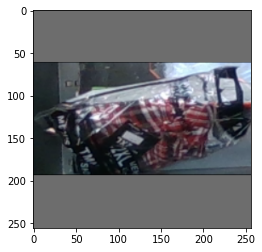

In [368]:
plt.imshow(val_gen[0][0].astype('int64'))

In [378]:
labs = train_df['y'].unique()
labs.sort()
labs

array([ 1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13])

In [380]:
off_res.loc[off_res['y'] > 13]

,preds,y
382,2.0,14
383,2.0,14
1041,3.0,14
1042,2.0,14
1050,2.0,14
...,...,...
5794,8.0,14
5805,8.0,14
6272,2.0,14
6300,11.0,14


In [369]:
off_res.loc[off_res['preds']!=off_res['y']].head(10)

,preds,y
23,4.0,8
28,4.0,8
36,4.0,8
38,4.0,9
39,4.0,8
43,4.0,8
48,4.0,9
50,4.0,8
51,8.0,9
65,4.0,8


In [373]:
deps = np.zeros((13,13))

for i in range(len(off_res)):
    
    deps[int(off_res.iloc[i]['preds']), int(off_res.iloc[i]['y'])] += 1

4, 4
4, 4
8, 8
4, 4
4, 8
8, 8
8, 8
4, 8
4, 4
4, 8
4, 9
4, 8
8, 8
8, 8
4, 8
4, 9
4, 8
8, 9
8, 8
4, 8
4, 9
9, 9
9, 9
6, 9
9, 9
9, 9
9, 9
9, 9
9, 9
9, 9
11, 11
11, 11
11, 11
1, 1
4, 1
5, 9
11, 11
9, 9
5, 1
1, 1
11, 11
4, 5
1, 1
4, 11
5, 5
5, 5
9, 9
1, 1
11, 11
11, 11
5, 5
4, 1
5, 5
4, 11
1, 1
3, 3
5, 10
5, 10
3, 3
3, 3
3, 3
4, 3
3, 3
10, 10
3, 3
3, 3
2, 2
4, 3
6, 2
3, 3
3, 3
3, 3
3, 3
2, 2
3, 3
4, 3
3, 3
3, 3
3, 3
3, 3
4, 3
10, 10
3, 3
2, 2
2, 14


IndexError: index 14 is out of bounds for axis 1 with size 13